# 執行模式

In [80]:
sc.master

u'local[*]'

# 資料準備

In [81]:
#讀取資料
global Path    
if sc.master[0:5]=="local" :
   Path="file:/home/hduser/pythonsparkexample/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"

In [82]:
#觀察資料型態
#Name無用, Sex and Embraked需要轉換成數值, Age and Cabin轉成float, ,SibSp and Parch有參考價值
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"data/train.csv")
rawDataWithHeader.take(2)

開始匯入資料...


[u'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked',
 u'1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S']

In [83]:
#將資料整理成label與特徵欄位
print("開始匯入資料...")
rawDataWithHeader = sc.textFile(Path+"data/train.csv")
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)
lines = rawData.map(lambda x: x.split(","))
newline = lines.map(lambda x: x[:3]+x[5:11]+[x[-1]])
print("共計：" + str(lines.count()) + "筆")

開始匯入資料...
共計：891筆


In [84]:
#第三和第四欄為名字，無參考價值，Cabin亦無參考價值
lines.take(1)[0][3:5]

[u'"Braund', u' Mr. Owen Harris"']

In [85]:
#資料只包含標籤與特徵欄位
newline.take(1)

[[u'1', u'0', u'3', u'male', u'22', u'1', u'0', u'A/5 21171', u'7.25', u'S']]

In [86]:
categoriesMap = newline.map(lambda x:x[-1]).distinct().zipWithIndex().collectAsMap()
categoriesMap

{u'': 1, u'C': 3, u'Q': 0, u'S': 2}

In [87]:
len(categoriesMap)

4

In [88]:
type(categoriesMap)

dict

In [89]:
#擷取特徵欄位Sex, Embarked
import numpy as np
#將Sex轉換為數值（male=1, female=0）
def genderIndex(x):
    if x=="male":
        return 1
    else:
        return 0
    
def convert_float(x):
    if x =="":
        return 0
    else:
        return float(x)
    
def embarkedIdx(x):
    if x[-1]=="C":
        return 1
    elif x[-1]=="Q":
        return 2
    else:
        return 3

#收集特徵
def extract_features(x):
    categoryFeatures = np.zeros(4)
    categoryFeatures[0] = genderIndex(x[3])
    if len(x[-1]) != 0:
        categoryFeatures[embarkedIdx(x)] = 1
    else:
        pass
    numericalFeatures=[x[2], convert_float(x[4]), x[5], x[6], convert_float(x[8])]
    return np.concatenate((categoryFeatures, numericalFeatures))
    
def extract_label(x):
    label = x[1]
    return float(label)

from pyspark.mllib.regression import LabeledPoint

labelpointRDD = newline.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [90]:
#將整理的資料儲存成labeledPointRDD
labelpointRDD.take(10)

[LabeledPoint(0.0, [1.0,0.0,0.0,1.0,3.0,22.0,1.0,0.0,7.25]),
 LabeledPoint(1.0, [0.0,1.0,0.0,0.0,1.0,38.0,1.0,0.0,71.2833]),
 LabeledPoint(1.0, [0.0,0.0,0.0,1.0,3.0,26.0,0.0,0.0,7.925]),
 LabeledPoint(1.0, [0.0,0.0,0.0,1.0,1.0,35.0,1.0,0.0,53.1]),
 LabeledPoint(0.0, [1.0,0.0,0.0,1.0,3.0,35.0,0.0,0.0,8.05]),
 LabeledPoint(0.0, [1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,8.4583]),
 LabeledPoint(0.0, [1.0,0.0,0.0,1.0,1.0,54.0,0.0,0.0,51.8625]),
 LabeledPoint(0.0, [1.0,0.0,0.0,1.0,3.0,2.0,3.0,1.0,21.075]),
 LabeledPoint(1.0, [0.0,0.0,0.0,1.0,3.0,27.0,0.0,2.0,11.1333]),
 LabeledPoint(1.0, [0.0,1.0,0.0,0.0,2.0,14.0,1.0,0.0,30.0708])]

In [91]:
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("將資料分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


將資料分trainData:725   validationData:71   testData:95


In [92]:
#資料準備
from pyspark.mllib.regression import LabeledPoint
import numpy as np
#將Sex轉換為數值（male=0, female=1）
def genderIndex(x):
    if x=="male":
        return 1
    else:
        return 0

def embarkedIdx(x):
    if x[-1]=="C":
        return 1
    elif x[-1]=="Q":
        return 2
    else:
        return 3
    
def convert_float(x):
    if x =="":
        return 0
    else:
        return float(x)

#收集特徵
def extract_features(x):
    categoryFeatures = np.zeros(4)
    categoryFeatures[0] = genderIndex(x[3])
    if len(x[-1]) != 0:
        categoryFeatures[embarkedIdx(x)] = 1
    else:
        pass
    numericalFeatures=[x[2], convert_float(x[4]), x[5], x[6], convert_float(x[8])]
    return np.concatenate((categoryFeatures, numericalFeatures))
    
def extract_label(x):
    label = x[1]
    return float(label)

def PrepareData(sc): 
    #----------------------1.匯入並轉換資料-------------
    global Path    
    if sc.master[0:5]=="local" :
       Path="file:/home/hduser/pythonsparkexample/PythonProject/"
    else:   
       Path="hdfs://master:9000/user/hduser/"

    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile(Path+"data/train.csv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)
    lines = rawData.map(lambda x: x.split(","))
    newline = lines.map(lambda x: x[:3]+x[5:])
    print("共計：" + str(lines.count()) + "筆")
    #----------2.建立訓練評估所需資料 RDD[LabeledPoint]-------    
    labelpointRDD = newline.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))
        
    #-----------3.以隨機方式將資料分為3部份並且回傳-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("將資料分為trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData) #回傳資料

(trainData, validationData, testData) =PrepareData(sc)
trainData.persist()
validationData.persist()
testData.persist()

開始匯入資料...
共計：891筆
將資料分為trainData:721   validationData:84   testData:86


PythonRDD[242] at RDD at PythonRDD.scala:48

# 訓練模型與預測資料

In [93]:
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
import csv

model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

#testdata沒有label欄位，所以選取特徵都必須往前挪一欄

def extract_features1(x):
    categoryFeatures = np.zeros(4)
    categoryFeatures[0] = genderIndex(x[2])
    if len(x[-1]) != 0:
        categoryFeatures[embarkedIdx(x)] = 1
    else:
        pass
    numericalFeatures=[x[1], convert_float(x[3]), x[4], x[5], convert_float(x[7])]
    return np.concatenate((categoryFeatures, numericalFeatures))

def PredictData(sc,model): 
    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile(Path+"data/test.csv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)
    lines = rawData.map(lambda x: x.split(","))
    newline = lines.map(lambda x: x[:2]+x[4:])
    print("共計：" + str(newline.count()) + "筆")
    dataRDD = newline.map(lambda r:(r[0], extract_features1(r)))
    DescDict = {
           0: "死亡",
           1: "倖存"
     }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print " 名單編號：  " +str(data[0])+"\n" +\
                  "             ==>預測:"+ str(predictResult)+ \
                  " 說明:"+DescDict[predictResult] +"\n"
    num = dataRDD.count()
    predictions = [(str(data[0]), int(model.predict(data[1]))) for data in dataRDD.take(num)]
    with open("prediction.csv", "w") as f:
        cw = csv.writer(f)
        cw.writerows(r for r in predictions)
        

print("==========預測資料===============")
PredictData(sc, model)   

==========預測資料===============
開始匯入資料...
共計：418筆
 名單編號：  892
             ==>預測:0.0 說明:死亡

 名單編號：  893
             ==>預測:0.0 說明:死亡

 名單編號：  894
             ==>預測:0.0 說明:死亡

 名單編號：  895
             ==>預測:0.0 說明:死亡

 名單編號：  896
             ==>預測:1.0 說明:倖存

 名單編號：  897
             ==>預測:0.0 說明:死亡

 名單編號：  898
             ==>預測:0.0 說明:死亡

 名單編號：  899
             ==>預測:0.0 說明:死亡

 名單編號：  900
             ==>預測:1.0 說明:倖存

 名單編號：  901
             ==>預測:0.0 說明:死亡



# 評估模型的準確率

In [94]:
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(5)

[(0.0, 0.0), (0.0, 0.0), (1.0, 1.0), (0.0, 0.0), (0.0, 0.0)]

In [95]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print "AUC="+str(metrics.areaUnderROC)

AUC=0.898148148148


In [96]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [97]:
AUC=evaluateModel(model, validationData)
print "AUC="+str(AUC)

AUC=0.898148148148


In [98]:
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print    "訓練評估：使用參數" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需時間="+str(duration) + \
                 " 結果AUC = " + str(AUC) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=3.4222779274 結果AUC = 0.898148148148
訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=2.05824804306 結果AUC = 0.734649122807


In [99]:
#測試gini and entropy何者較佳
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=2.76986193657 結果AUC = 0.812962962963
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.77896308899 結果AUC = 0.82962962963


In [100]:
#AUC, duration, impurity, maxDepth, maxBins, model
metrics

[(0.8129629629629629,
  2.769861936569214,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 279 nodes),
 (0.8296296296296296,
  1.7789630889892578,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 265 nodes)]

In [101]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.812963,2.769862,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.829630,1.778963,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


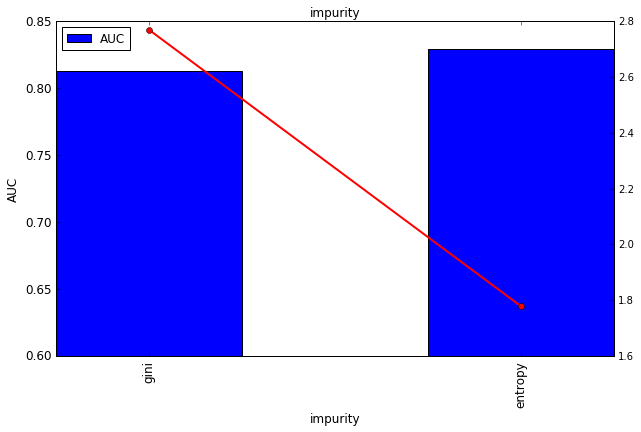

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.6,0.85])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
plt.show()

In [103]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

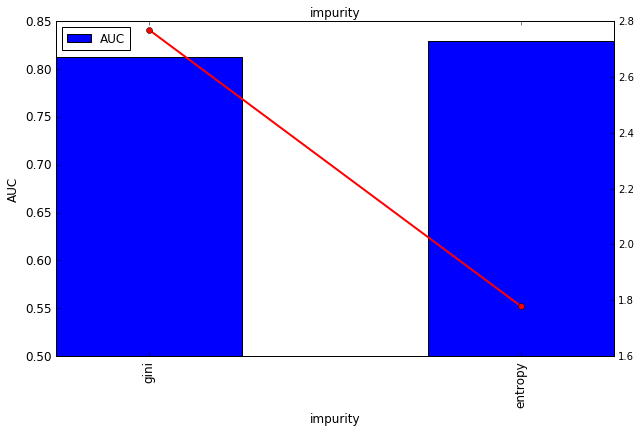

In [114]:
showchart(df,'impurity','AUC','duration',0.5,0.85 )

# 找出最好的評估參數

In [118]:
#定義evalParameter函數
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #訓練評估參數
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #設定目前評估的參數
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #轉換為Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #顯示圖形
    showchart(df,evalparm,'AUC','duration',0.5,0.9 )

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.56891393661 結果AUC = 0.812962962963
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=1.4875600338 結果AUC = 0.82962962963


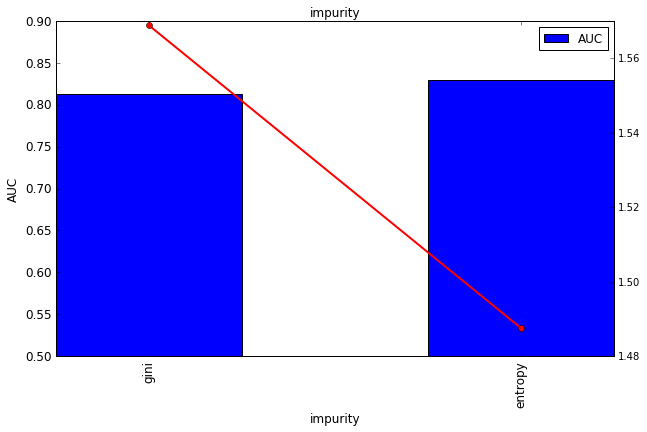

In [119]:
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10 ])  

訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=0.806505918503 結果AUC = 0.816666666667
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=0.860651016235 結果AUC = 0.866666666667
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.43497300148 結果AUC = 0.812962962963
訓練評估：使用參數 impurity=gini maxDepth=15 maxBins=10
 ==>所需時間=0.9979429245 結果AUC = 0.812962962963
訓練評估：使用參數 impurity=gini maxDepth=20 maxBins=10
 ==>所需時間=1.57853412628 結果AUC = 0.812962962963
訓練評估：使用參數 impurity=gini maxDepth=25 maxBins=10
 ==>所需時間=1.91138601303 結果AUC = 0.812962962963


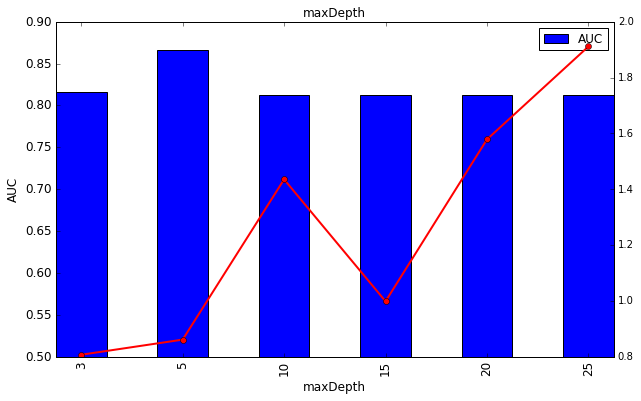

In [120]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=3
 ==>所需時間=1.35019803047 結果AUC = 0.848148148148
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=1.63691997528 結果AUC = 0.844444444444
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=1.42515587807 結果AUC = 0.812962962963
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=50
 ==>所需時間=1.12045502663 結果AUC = 0.855555555556
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=100
 ==>所需時間=0.866549968719 結果AUC = 0.838888888889
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=200
 ==>所需時間=0.896891832352 結果AUC = 0.864814814815


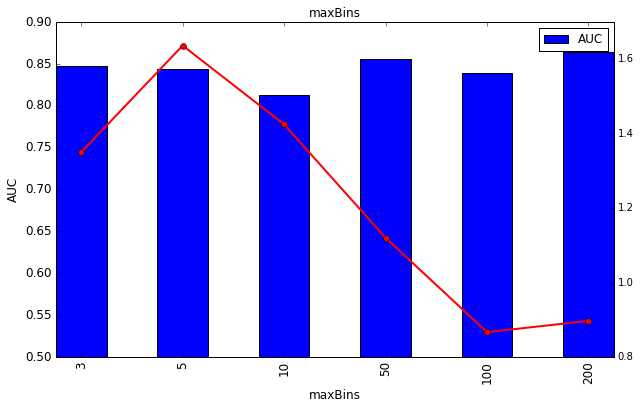

In [121]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

In [122]:
#定義evalAllParameter函數
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for迴圈訓練評估所有參數組合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的參數組合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #顯示調校後最佳參數組合      
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    結果AUC = " + str(bestParameter[0]))
    #傳回最佳模型
    return bestParameter[5]

In [123]:
    print("-----所有參數訓練評估找出最好的參數組合---------")  
    bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])

-----所有參數訓練評估找出最好的參數組合---------
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=3
 ==>所需時間=0.707546949387 結果AUC = 0.816666666667
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=5
 ==>所需時間=0.853150844574 結果AUC = 0.816666666667
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=1.32136106491 結果AUC = 0.816666666667
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=50
 ==>所需時間=1.15638208389 結果AUC = 0.855555555556
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=100
 ==>所需時間=0.745249032974 結果AUC = 0.855555555556
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=200
 ==>所需時間=0.730937957764 結果AUC = 0.855555555556
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=3
 ==>所需時間=0.873770952225 結果AUC = 0.788888888889
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=5
 ==>所需時間=0.731662988663 結果AUC = 0.809259259259
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=1.26180100441 結果AUC = 0.866666666667
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=50
 ==>所需時間=0.837016820908 結果AUC = 0.840740740741
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=

In [124]:
#確認傳回的最佳模型是否有overfitting的問題
AUC=evaluateModel(model, testData)
print "AUC="+str(AUC)

AUC=0.734649122807
